##Causal vs. Non-causal Learning using Neural Networks

In [2]:
%load_ext autoreload
import numpy as np
from numpy.polynomial.polynomial import polyval
import numpy.random as rd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

%matplotlib inline

sys.path.append('./NeuralNetworks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Configuration for plots

fig_size = (12,8)
font_size = 14

##Learning causal relationship - The Feed-Forward Network architecture

We want to learn a non-linear simple input-output relationship using a neural network. The data is generated from a cubic polynomial with some noise added.

In [4]:
def drawFromCubic(x_min, x_max, lst_of_coefficients, n_samples, noise_x, noise_y):
    x = np.linspace(x_min, x_max, 10000)
    sample_x = rd.choice(x, size=n_samples)
    sample_y = polyval(sample_x, lst_of_coefficients)
    return sample_x + rd.normal(scale=noise_x, size=n_samples), sample_y + rd.normal(scale=noise_y, size=n_samples)

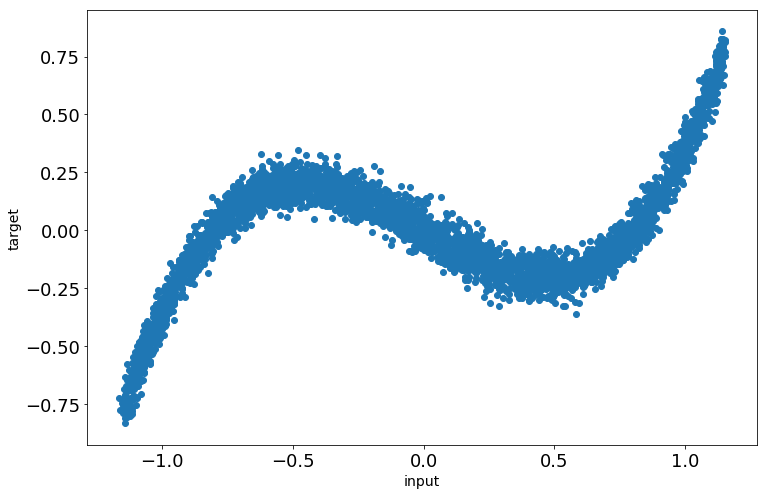

In [5]:
n_samples = 4000
y_train, x_train = drawFromCubic(-1.15, 1.15, [0, -.65, 0, 1], n_samples, 0.01, 0.05)

n_test_samples = 500
y_test, x_test = drawFromCubic(-1.15, 1.15, [0, -.65, 0, 1], n_test_samples, 0.01, 0.05)

plt.figure(figsize=fig_size);
plt.scatter(y_train, x_train);

plt.xlabel('input', fontsize=font_size);
plt.ylabel('target', fontsize=font_size);

fig = plt.gcf();
fig.set_figwidth(12);
fig.set_figheight(8);
plt.xticks(size = 18);
plt.yticks(size = 18);

###Causal relation

In this section we learn the above relationship using a simple Feed-Forward Network architecture.

In [6]:
import SimpleNeuralNets.FeedForwardNN.FFNN as ffn
import theano.tensor as tensor
import theano

X = tensor.dmatrix("X")
y = tensor.dvector("y")
network = ffn.FFNN(X, y, 1, [25], 1, [tensor.tanh], out_activation = None,
                   **{'normalized_gradient' : True})

kwargs = {
    'print_loss': False,
    'n_iterations': 10000,
    'learning_rate': 0.001
}

ffn_losses, ffn_test_losses = network.train(y_train.reshape([n_samples, 1]),
                                    x_train,
                                    test_input=y_test.reshape([n_test_samples, 1]),
                                    test_target=x_test,
                                    **kwargs)

ImportError: No module named SimpleNeuralNets.FeedForwardNN.FFNN

In [ ]:
plt.figure(figsize=fig_size);
plt.loglog(ffn_losses, label = 'train');
plt.loglog(ffn_test_losses, label = 'test');

plt.xlabel('input', fontsize=font_size);
plt.ylabel('loss', fontsize=font_size);
plt.legend(fontsize=18);

fig = plt.gcf();
fig.set_figwidth(12);
fig.set_figheight(8);
plt.xticks(size = 18);
plt.yticks(size = 18);

In [ ]:
x_test_plot = np.linspace(-1.25,1.25,2000).reshape([2000,1])

plt.figure(figsize=fig_size)
plt.plot(y_train, x_train, 'ro', alpha=0.05);
plt.plot(x_test_plot, network.predict(x_test_plot), linewidth=3, color='k');
plt.xlabel('input', fontsize=font_size);
plt.ylabel('target', fontsize=font_size);

fig = plt.gcf();
fig.set_figwidth(12);
fig.set_figheight(8);
plt.xticks(size = 18);
plt.yticks(size = 18);

###Noncausal relation with a Feed-Forward Network

Let's switch the input with the target variable. The relation is now a multi-valued function and hence cannot be represented by a straight-forward input-output relation. We see that the FFN is not very apt at learning the target. This is because the FFN has causality fundamentally built into its architecture.

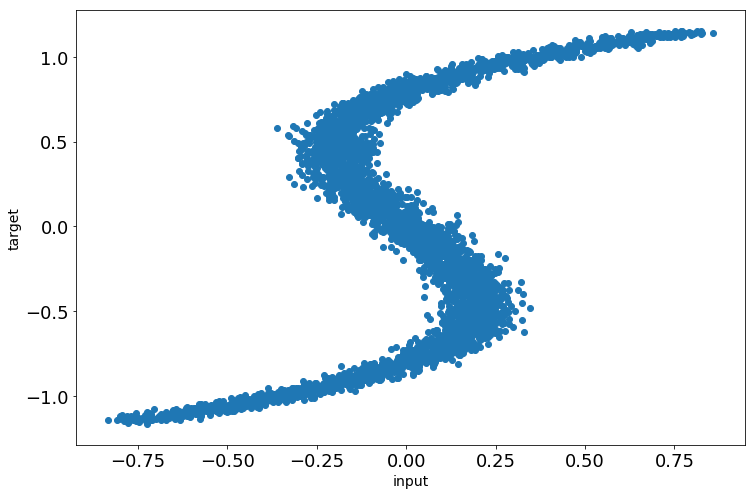

In [7]:
plt.figure(figsize=fig_size);
plt.scatter(x_train, y_train);

plt.xlabel('input', fontsize=font_size);
plt.ylabel('target', fontsize=font_size);

fig = plt.gcf();
fig.set_figwidth(12);
fig.set_figheight(8);
plt.xticks(size = 18);
plt.yticks(size = 18);

In [8]:
import SimpleNeuralNets.FeedForwardNN.FFNN as ffn
import theano.tensor as tensor
import theano

X = tensor.dmatrix("X")
y = tensor.dvector("y")
network = ffn.FFNN(X, y, 1, [25], 1, [tensor.tanh], out_activation = None,
                   **{'normalized_gradient' : True})

kwargs = {
    'print_loss': False,
    'n_iterations': 10000,
    'learning_rate': 0.001
}

losses, test_losses = network.train(x_train.reshape([n_samples, 1]),
                                    y_train,
                                    test_input=x_test.reshape([n_test_samples, 1]),
                                    test_target=y_test,
                                    **kwargs)

ImportError: No module named SimpleNeuralNets.FeedForwardNN.FFNN

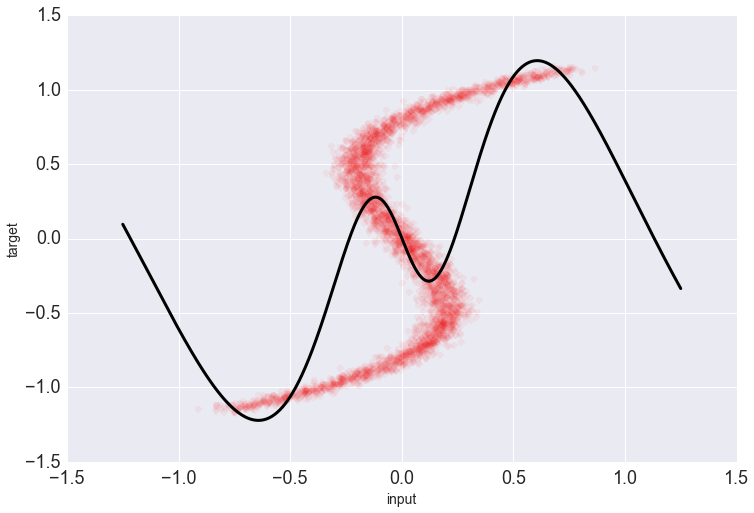

In [34]:
x_test_plot = np.linspace(-1.25,1.25,2000).reshape([2000,1])

plt.figure(figsize=fig_size)
plt.plot(x_train, y_train, 'ro', alpha=0.05);
plt.plot(x_test_plot, network.predict(x_test_plot), linewidth=3, color='k');
plt.xlabel('input', fontsize=font_size);
plt.ylabel('target', fontsize=font_size);

fig = plt.gcf();
fig.set_figwidth(12);
fig.set_figheight(8);
plt.xticks(size = 18);
plt.yticks(size = 18);

##Learning a Non-Causal Relationship -- the Mixture Density Model

To enable a Neural Network to learn multiple outputs we have to allow for functions that mimick several values at the same time. A way to do this is to give a probability estimate of how likely it is to pick a given value of the multi-valued relation. To achieve this the Mixture Density Model (MDN) learns the parameters of a sum of probability distributions. Let's get started.

In [37]:
def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu,2)/(2 * np.power(sigma, 2))) / np.sqrt(2 * np.pi * np.power(sigma, 2))

def gaussian_array(x, y, mu, sigma, mix):
    n_dim = mu.shape[0]
    lst = []
    for idx in range(len(x)):
        val = 0
        for dim in range(n_dim):
            val += mix[dim, idx] * gaussian(y, mu[dim, idx], sigma[dim, idx])
        lst.append(val)
    return np.array(lst).T

In [38]:
import SimpleNeuralNets.MixtureDensityModel.MDN as mdn
import theano.tensor as tensor
import theano

X = tensor.dmatrix("X")
y = tensor.dvector("y")
network = mdn.MDN(X, y, 1, [10, 10], 1, 3, [tensor.tanh, tensor.tanh],
                  **{'normalized_gradient': True})

kwargs = {
    'l1_strength': 5,
    'learning_rate': 0.01, 
    'n_iterations': 50000,
    'print_loss': False,
    'sigma_weight_init' : 0.1
}

losses, test_losses = network.train(x_train.reshape([n_samples, 1]),
                                    y_train,
                                    test_input=x_test.reshape([n_test_samples, 1]),
                                    test_target=y_test,
                                    **kwargs)

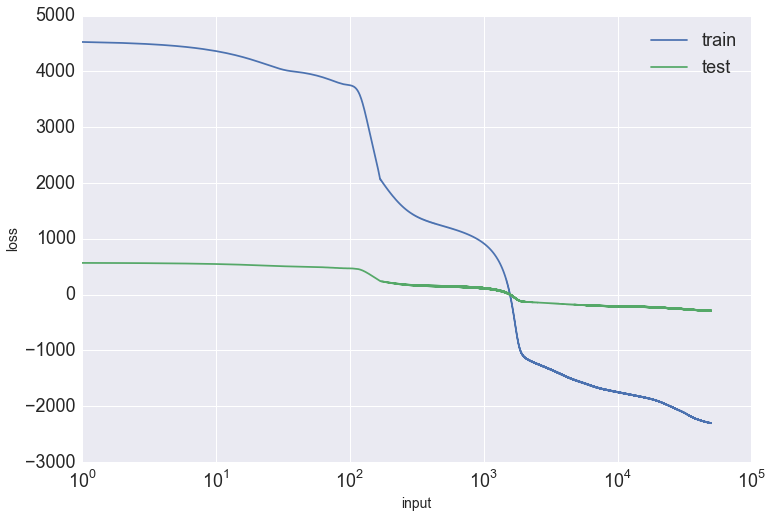

In [39]:
plt.figure(figsize=fig_size);
plt.semilogx(losses, label = 'train');
plt.semilogx(test_losses, label = 'test');

plt.xlabel('input', fontsize=font_size);
plt.ylabel('loss', fontsize=font_size);
plt.legend(fontsize=18);

fig = plt.gcf();
fig.set_figwidth(12);
fig.set_figheight(8);
plt.xticks(size = 18);
plt.yticks(size = 18);

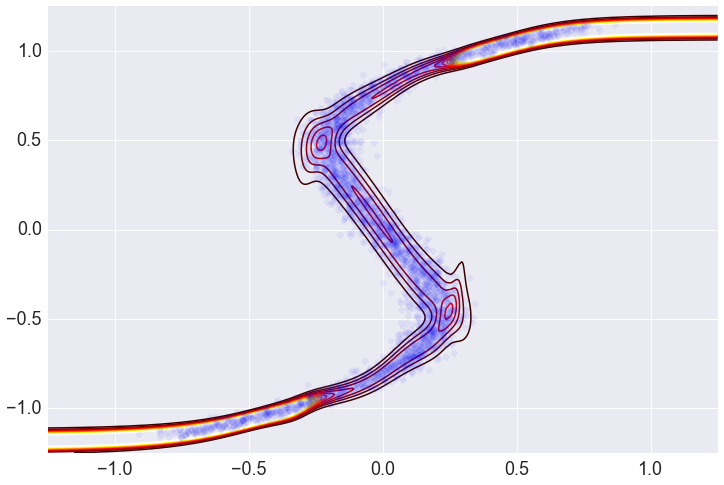

In [40]:
from matplotlib import cm

n_points = 1000
x_test_plot = np.sort(rd.uniform(low=-1.25, high=1.25, size=n_points)).reshape([n_points,1])
y_test_plot = np.linspace(-1.25,1.25, 500)

mu, sigma, mix = network.predict_params(x_test_plot)
arr = gaussian_array(x_test_plot, y_test_plot, mu, sigma, mix)
X, Y = np.meshgrid(x_test_plot, y_test_plot)

plt.figure(figsize=fig_size)
plt.plot(x_train, y_train, 'bo', alpha = 0.05);
plt.contour(X, Y, arr, linewidths=1.5, levels=np.arange(0, 7.5, .5), cmap=cm.hot);

fig = plt.gcf();
fig.set_figwidth(12);
fig.set_figheight(8);
plt.xticks(size = 18);
plt.yticks(size = 18);